In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper


In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query Arxiv papers")
print(arxiv.name)

arxiv


In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Query Wikipedia")
print(wiki.name)

wikipedia


In [6]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [9]:
tools = [arxiv, wiki, tavily]

In [12]:
## Initialize the LLM Model
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-qwq-32b")

In [15]:
llm_with_tools=llm.bind_tools(tools=tools)

##WorkFlow

In [17]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ##  Human message or AI message
from typing import Annotated ##labeling
from langgraph.graph.message import add_messages  ## Reducers in LangGraph

In [18]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

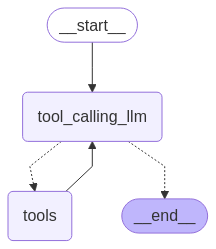

In [40]:
def tool_calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
messages = graph.invoke({"messages": "what is the recent AI news and then tell me the recent reseach paper in quantum computing?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the recent AI news and then tell me the recent reseach paper in quantum computing?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_46ca)
 Call ID: call_46ca
  Args:
    query: recent AI news
  arxiv (call_ee48)
 Call ID: call_ee48
  Args:
    query: quantum computing
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The latest AI news we announced in March - Google Blog", "url": "https://blog.google/technology/ai/google-ai-updates-march-2025/", "content": "The latest AI news we announced in March\n\nApr 04, 2025\n\n[[read-time]] min read\n\nHere’s a recap of some of our biggest AI updates from March, including Gemini 2.5 Pro, expanded access to AI Overviews, the release of AI Mode and more.\n\nGeneral summary [...] March was all about expandin